In [1]:
# import tensorflow as tf
# sess = tf.Session()
import itertools
import keras
from keras import backend as K
# K.set_session(sess)
import h5py

from keras.models import Model
from keras.layers import Dense, LSTM, Input, Embedding, GRU, Masking, Dropout, Lambda, Flatten, concatenate, Conv1D, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import numpy as np

from lm_train_helpers import load_lm_model
import os

Using TensorFlow backend.


In [2]:
# Problem parameters
# context_size = 50
max_len = 280
n_energies = 20
n_chars = 27 # 27 chars including space
eos_idx = n_chars
bos_idx = n_chars + 1
block_rf = 1
for i in range(layers_per_block):
    dilation_rate = 2**i
    block_rf += dilation_rate*((kernel_size-1)/2)
print "block_rf =", block_rf

NameError: name 'layers_per_block' is not defined

In [4]:
corpus_file = open("language_model_dat/processed-text-clean-v2-heldout.txt")
lines = corpus_file.readlines()
len(lines)

306688

In [5]:
lines[213123]

'peterson cut the interview short when he was asked about reports of a blue barrel that disappeared from his home the day after stacy disappeared\n'

In [6]:
# index to byte mapping
index2byte = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
              'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q',
              'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "\n"]
# byte to index mapping
byte2index = dict(zip(index2byte, range(len(index2byte))))
assert index2byte[eos_idx] == "\n"



In [7]:
coded_lines = np.load("coded_clean_texts_heldout.npy")

In [8]:
len(coded_lines)

291083

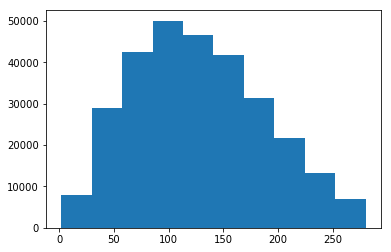

In [9]:
plt.hist(map(len, coded_lines));

In [10]:
# architecture parameters
embed_size = 64
n_blocks = 1
layers_per_block = 5
n_filters = 32
kernel_size = 3
activation = "relu"
block_rf = 1
for i in range(layers_per_block):
    dilation_rate = 2**i
    block_rf += dilation_rate*(kernel_size-1)
print "block_rf =", block_rf

block_rf = 63


In [3]:
# # Simple residual block without multiplicative gates or size-1 time convolutions
# def causal_res_block(prev):
#     r = prev
#     for x in range(layers_per_block):
#         print x 
#         dilation_rate = 2**x
#         linear = Conv1D(n_filters, 
#                         kernel_size, 
#                         padding='causal', 
#                         dilation_rate=dilation_rate, 
#                         activation="linear")(r)
#         batch_normed = BatchNormalization()(linear)
#         a = Activation(activation)(batch_normed)
#         r = concatenate([a, r])
#     return r

# # print "Creating model ", model_name
        
# # Input tensors include labels, input lengths and label lengths because we define the cost tensor explicitly
# chars = Input(shape=(max_len+1,), name="chars")
# embed = Embedding(input_dim = n_chars + 2, output_dim = 64, name = "embed")(chars)
# # print keras.backend.shape(embed)

# r = embed
# for i in range(n_blocks):
#     r = res_block(r)
# logits = BatchNormalization()(Conv1D(n_chars+1, 
#                                      kernel_size,
#                                      padding='causal', 
#                                      dilation_rate=1, 
#                                      activation="linear")(r))
# char_probs = Activation("softmax", name = "char_probs")(logits)

# # Keras doesn't currently support loss funcs with extra parameters
# # so CTC loss is implemented in a lambda layer

# # Create the model and compile
# model = Model(inputs=[chars], outputs=[char_probs])
model, highest_epoch = load_lm_model("lm_char_e64.b1.l5.f128.k7.relu")
model.summary()
# clipnorm seems to speeds up convergence
# sgd = Adam(lr=0.001)
# model.compile(loss='categorical_crossentropy', optimizer=sgd)

Loading model lm_char_e64.b1.l5.f128.k7.relu
Looking for files with mode "best"
File lm_char_e64.b1.l5.f128.k7.relu-0-999999999.0.h5 contains weights after 0 epochs achieving validation loss: 999999999.0
File lm_char_e64.b1.l5.f128.k7.relu-1-0.529878948667.h5 contains weights after 1 epochs achieving validation loss: 0.529878948667
File lm_char_e64.b1.l5.f128.k7.relu-0-0.535017237709.h5 contains weights after 0 epochs achieving validation loss: 0.535017237709
Best weights are from lm_char_e64.b1.l5.f128.k7.relu-1-0.529878948667.h5
Loading weights...


ValueError: Tensor conversion requested dtype int32 for Tensor with dtype float32: 'Tensor("embed/random_uniform:0", shape=(29, 64), dtype=float32)'

In [15]:
with_bos = [[bos_idx]+line_code for line_code in coded_lines]
X_batch = pad_sequences(with_bos, max_len+1, padding='post', truncating='post', value=eos_idx) # plus one for the bos
padded_labels = pad_sequences(coded_lines, max_len+1, padding='post', truncating='post', value=eos_idx)
y_batch = np.asarray([to_categorical(a, num_classes=n_chars+1) for a in padded_labels])
            


In [19]:
X_batch.shape

(291083, 281)

In [24]:
y_pred_probs = model.predict(X_batch[:1000])
y_preds = np.argmax(y_pred_probs, axis=2)

In [28]:
sample_idx = 0
sample_pred = y_preds[sample_idx]
actual_code = np.argmax(y_batch[sample_idx], axis=1)
sample_chars = [index2byte[x] for x in sample_pred]
actual_chars = [index2byte[x] for x in actual_code]

In [27]:
"".join(sample_chars)

'tuth taoton wnd talrr wav becused to commee with tocsoena  an ues ay the somputtee ohth the coite house aneumng that t vice tesoived ay trosident oeorge w bush aoom tis prdes aaould becain irocate snd tontidencial \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

In [29]:
"".join(actual_chars)

'both bolten and miers had refused to comply with subpoenas issued by the committee with the white house arguing that advice received by president george w bush from his aides should remain private and confidential\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'